# 使用Pytorch解决回归问题

In [3]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # 每类样本的数量
D = 1  # 每个样本的特征维度
C = 1  # 类别数
H = 100  # 隐层的神经元数量

X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (100, 1)
y: (100, 1)


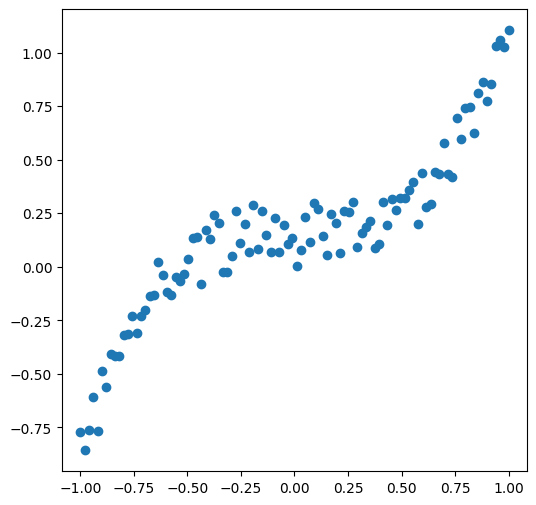

In [5]:
# 在坐标系上显示数据
plt.figure(figsize=(6, 6))
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');


## 1. 建立线性模型 (两层网络间没有激活函数)

In [6]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# 建立神经网络模型
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # 模型转到 GPU

# 对于回归问题，使用MSE损失函数
criterion = torch.nn.MSELoss()

# 定义优化器，使用SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# 开始训练
for t in range(1000):
    # 数据输入模型得到预测结果
    y_pred = model(X)
    # 计算 MSE 损失
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    # 反向传播前，梯度清零
    optimizer.zero_grad()
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.029701


Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


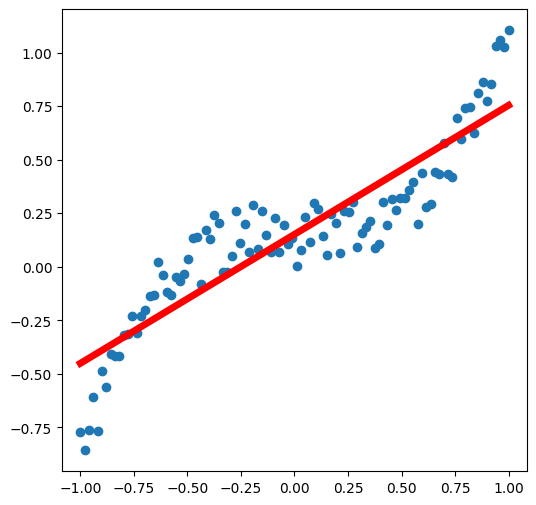

In [7]:
# 展示模型与结果
print(model)
plt.figure(figsize=(6,6))
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');


## 2. 两层神经网络

In [9]:
# 这里定义了2个网络，一个 relu_model，一个 tanh_model，
# 使用了不同的激活函数
relu_model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU(),
        nn.Linear(H, C)
)
relu_model.to(device)

tanh_model = nn.Sequential(
        nn.Linear(D, H),
        nn.Tanh(),
        nn.Linear(H, C)   
)
tanh_model.to(device)

# MSE损失函数
criterion = torch.nn.MSELoss()
# 定义优化器，使用 Adam，这里仍使用 SGD 优化器的化效果会比较差，具体原因请自行百度
optimizer_relumodel = torch.optim.Adam(relu_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 
optimizer_tanhmodel = torch.optim.Adam(tanh_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

# 开始训练
for t in range(1000):
    y_pred_relumodel = relu_model(X)
    y_pred_tanhmodel = tanh_model(X)
    # 计算损失与准确率
    loss_relumodel = criterion(y_pred_relumodel, y)
    loss_tanhmodel = criterion(y_pred_tanhmodel, y)
    print(f"[MODEL]: relu_model, [EPOCH]: {t}, [LOSS]: {loss_relumodel.item():.6f}")
    print(f"[MODEL]: tanh_model, [EPOCH]: {t}, [LOSS]: {loss_tanhmodel.item():.6f}")    
    display.clear_output(wait=True)

    optimizer_relumodel.zero_grad()
    optimizer_tanhmodel.zero_grad()
    loss_relumodel.backward()
    loss_tanhmodel.backward()
    optimizer_relumodel.step()
    optimizer_tanhmodel.step()


[MODEL]: relu_model, [EPOCH]: 999, [LOSS]: 0.006479
[MODEL]: tanh_model, [EPOCH]: 999, [LOSS]: 0.007934


## 3. 展示回归结果

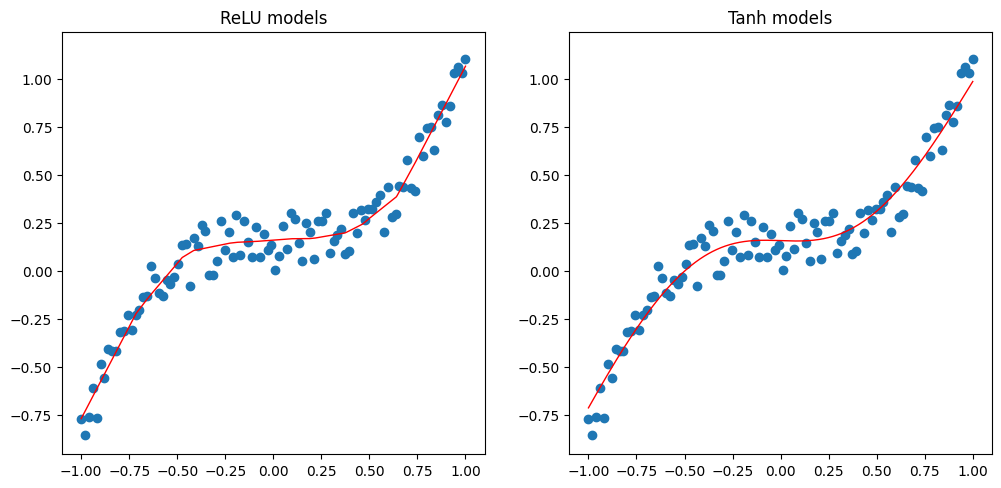

In [10]:
plt.figure(figsize=(12, 6))

def dense_prediction(model, non_linearity):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    X_new = torch.unsqueeze(torch.linspace(-1, 1, 1001), dim=1).to(device)
    with torch.no_grad():
        y_pred = model(X_new)
    plt.plot(X_new.cpu().numpy(), y_pred.cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.title(non_linearity + ' models')

dense_prediction(relu_model, 'ReLU')
dense_prediction(tanh_model, 'Tanh')
